## La vida del data scientist

El equipo de marketing de la empresa X quiere tomar decisiones para alocar presupuesto en base al valor futuro de los usuarios. Para ello se nos ha encargado desarrollar un modelo de LTV(file time value) que consista en predecir el valor futuro de cada usuario.

Debido a que esta problematica es compleja, vamos a dividir el problema en 3 partes:

- 1- Vamos a hacer un analisis clasico llamado RFM para entender como se segmentan nuestros usuarios

- 2- Vamos a ponerle un valor a la cantidad de compras que realizará a futuro

Para ello, se nos ha proporcionado un dataset -que afortunadamente nos dejaron los datos limpios (esto solo pasa en la facultad jeje)- para que podamos entrenar nuestro modelo. 

El datset consiste en los siguientes campos:
- cust: ID del usuarios
- Freq_3M: Dias distintos de pago en ultimos 3 meses
- Recency: Cantidad de dias desde ultima compra
- first_in_windows: Cantidad de dias desde primer compra

## 1) Levantamos el dataset

In [1]:
import pandas as pd

dataset = pd.read_csv("DATASET_LTV.csv",sep = ";")
dataset.head()

,cust,Recency,first_in_windows,Freq_2Y,Freq_1Y,Freq_3M,IPT_mean,CREDIT_PAY,TIPO_TARJETA,CUS_FIRST_BUY,CANTIDAD_COMPRAS_ITEMS_USADOS,cant_dias_active_short,recency_date_short,Frequency_target
0,378518804,294.0,294.0,1,1,0.0,9.999999e+06,1.0,2.0,294.0,0,0.0,9999999.0,0.0
1,389613070,4.0,4.0,1,1,1.0,9.999999e+06,0.0,0.0,4.0,0,0.0,9999999.0,0.0
2,56668186,42.0,545.0,9,8,2.0,1.304561e+00,8.0,4.0,3114.0,0,1.0,27.0,14.0
3,307374346,14.0,544.0,6,5,1.0,1.301598e+00,7.0,2.0,544.0,0,3.0,1.0,6.0
4,211220646,31.0,48.0,3,3,3.0,9.097720e-01,0.0,0.0,48.0,0,5.0,16.0,1.0


# 2) SEGMENTANDO LA BASE DE USUARIOS
Vamos a aplicar K means sobre la base de usuarios para ver si encontramos segmentos de usuarios. Para ello vamos a usar los campos Recency, first_in_windows,Freq_2Y. Esta técnica se conoce como RFM y es muy usada en marketing.

Como vimos recien para usar Kmeans necesitamos definir cuantos clusters vamos a querer, pero como de antemano no lo sabemos vamos a usar el método del códo. Este consiste en hacer kmeans con distintos K y medir cual es la distorción promedio del cluster. Un buen K lo vamos a ver cuando la distorción llegue a un punto de inflexion (codo)

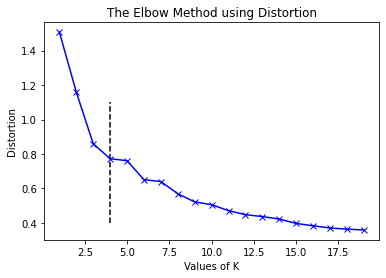

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
import numpy as np

# hacemos todo de una. Llamo al modelo standard scaler y despues entreno y transformo en un mismo paso
# Como estamos explorando nada mas, no importa nos separamos testing y training.
X_cluster = StandardScaler().fit_transform(dataset[["Recency","first_in_windows","Freq_2Y"]]) 

# Ahora su turno. Hay que calcular cual es la cantidad optima de clusters usando el metodo del codo. Recordemos que tenemos que interpretar los resultados despues!
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

distortions = []
for k in range(1,20):
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,n_jobs=-1)
    kmeanModel.fit(X_cluster)     
    
    distortions.append(sum(np.min(cdist(X_cluster, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X_cluster.shape[0]) 

plt.plot(list(range(1,20)), distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 

plt.vlines(x = 4,ymin=0.4,ymax=1.1,linestyles="dashed",color="black")

Ahora que sabemos el valor de nuestro K, vamos a fitear un Kmeans sobre nuestro dataset y a explorar que entendió el modelo...

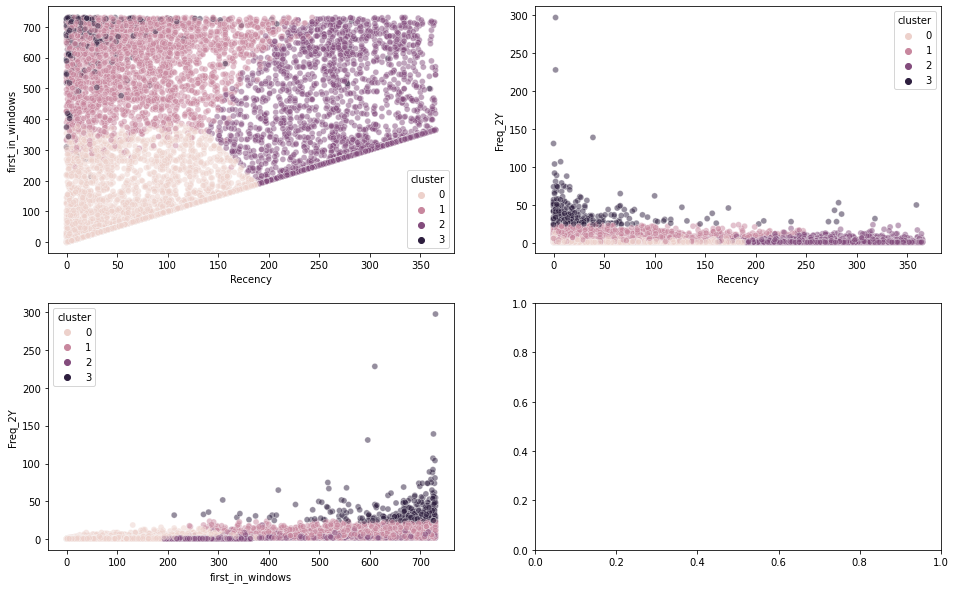

In [3]:
import seaborn as sns

OPTIMAL_K = 4 # del metodo del codo aprendimos que una cuena cantidad de clusters interpretables es de 4
kmean = KMeans(n_clusters=OPTIMAL_K,n_jobs=-1) # instancio el modelo
kmean.fit(X_cluster) # entreno
dataset["cluster"] = kmean.predict(X_cluster) # aplico

fig, axs = plt.subplots(2, 2,figsize=(16,10))

sns.scatterplot(
    x="Recency", y="first_in_windows",
    hue="cluster",
    data=dataset,
    legend="full",
    alpha=0.5,
    ax = axs[0,0]
)

sns.scatterplot(
    x="first_in_windows", y="Freq_2Y",
    hue="cluster",
#     palette=sns.color_palette("hls", 10),
    data=dataset,
    legend="full",
    alpha=0.5,
    ax = axs[1,0]
)

sns.scatterplot(
    x="Recency", y="Freq_2Y",
    hue="cluster",
#     palette=sns.color_palette("hls", 10),
    data=dataset,
    legend="full",
    alpha=0.5,
    ax = axs[0,1]
)

Bueno ya con esta segmentación bastante sencilla podemos ejecutar distintas estrategias de marketing dependiendo de los segmentos de usuarios. Los usuarios frecuentes, que compraron hace poco y estan desde hace mucho son los mejores. Los que compraron una vez hace mucho tiempo y nunca mas volvieron son nuestros peores usuarios, vamos a tener que gastarnos mucha plata para recuperarlos y el retorno que nos dejarán es bajo...

# 3) Forecast

Pero no nos conformamos con una segmentación, si bien es de mucha utlidad para explicar a la gerencia, nosotros queremos ir mas alla y poder decir para cada usuario cuanto valor generará a futuro. Para ello vamos a usar el framework BTYD que de forma sencilla nos va a dar una predicción

In [4]:
!pip install lifetimes

     |████████████████████████████████| 584 kB 5.2 MB/s 


In [14]:
from lifetimes import ParetoNBDFitter
import numpy as np

dataset["recency_lifetimes"] =  dataset["first_in_windows"] - dataset["Recency"] # transformamos los datos porque lo requiere BTYD

bgf = ParetoNBDFitter() # Instanciamos al modelo
bgf.fit(dataset['Freq_2Y'], dataset['recency_lifetimes'], dataset['first_in_windows'])  # fit del modelo. Bayesian inference

# Dibujamos muestras de la distribución aprendida con un horizonte de 1 año
dataset["n_purchases_pred"] = dataset.apply(lambda y: bgf.conditional_expected_number_of_purchases_up_to_time(52, y['Freq_2Y'], y['recency_lifetimes'], y['first_in_windows']),axis = 1)

# Calculamos la probabilidad de estar vivo al dia de hoy
def apply_pAlive(z):  # hay modelos que devuelve una lista como proba, hay que hacer un unpak en estos casos
    y = bgf.conditional_probability_alive(z['Freq_2Y'], z['recency_lifetimes'], z['first_in_windows'])
    if(type(y) == np.ndarray):
        return y[0]
    else:
        return y

dataset["p_alive"] = dataset.apply(lambda z: apply_pAlive(z),axis = 1)


Como hacemos para segmentar estos valores futuros en algo explicable de forma facil? Algo muy sencillo es agruparlo en quintiles, grupos ordenados por frecuencia predicha de 20%

Text(0, 0.5, 'Predicted Frequency')

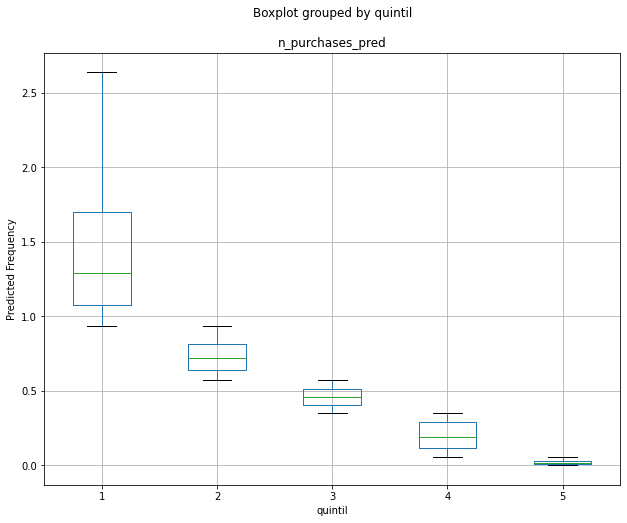

In [33]:
def asigno_quintiles_5(x):
    step = int(x.shape[0]*0.2)
    l_= []
    for i in range(4):
        l_ = l_ + [i+1]*step
    l_ = l_ + [5]*(x.shape[0] - len(l_)) 
    return l_  

dataset = dataset.sort_values(by = "n_purchases_pred",ascending=False)
dataset["quintil"] = asigno_quintiles_5(dataset)


fig, ax = plt.subplots(figsize=(10,8))
dataset.boxplot(column=['n_purchases_pred'], by='quintil',ax=ax,showfliers=False)
plt.ylabel("Predicted Frequency")

Que quiere decir p_alive? Cual es su correlato con la recencia?

Text(0, 0.5, 'Probabilidad de estar vivo')

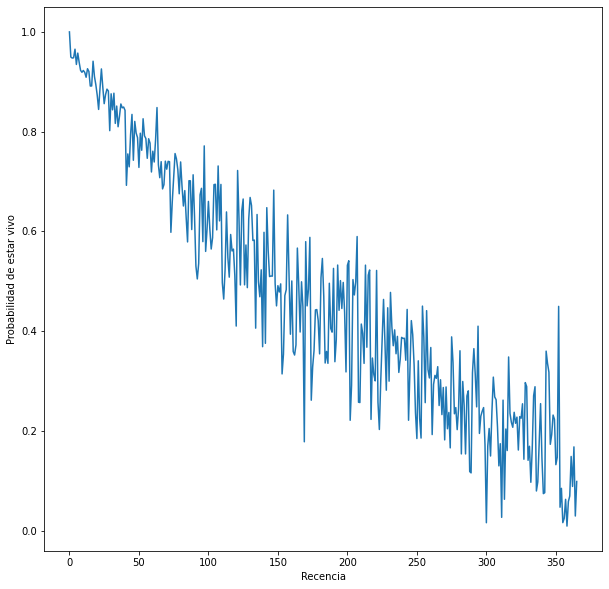

In [36]:
df_recency = dataset.groupby("Recency").p_alive.mean().reset_index()

plt.figure(figsize=(10,10))
plt.plot(df_recency.Recency,df_recency.p_alive)
plt.xlabel("Recencia")
plt.ylabel("Probabilidad de estar vivo")

Ya tenemos a que cluster pretencen los usuarios, cual es su frecuencia futura y su probabilidad de estar vivo al dia de hoy. Se animan a sacar insights accionales? Supongamos que la gente gasta 40 dolares en cada compra. Que grupo es mas rentable?


Pista: Mis usuarios buenos, voy a querer retenerlos (p_alive + cluster), Mis usuarios que conozco poco, cuando compran voy a querer incentivarlos a que sigan conociendo el producto(p_alive + cluster). 

In [33]:
dataset.to_csv("To_excel.csv",index=False,sep=",")